# Tarea Examen 2
### Teoría de Portafolios

### Equipo:
* Arath Alejandro Reyes López
* Natasha Montserrath Ortiz Castañeda
* Karla Michell Trigueros Torres

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

### 1-  Considera los cuatro assests: Apple, Nike, Google y Amazon. Lee los datos históricos a partir del 01/01/2022.

In [2]:
tickers = ["AAPL","NKE","GOOG","AMZN"]
start = "2022-1-1"
data = yf.download(tickers, start = start)
data = data["Adj Close"]
data = data.dropna()

[*********************100%***********************]  4 of 4 completed


### 2- Calcula los precios de return diarios del portafolio cuando el vector de peso w = (0.2, 0.4, 0.3, 0.1)

In [3]:
log_returns = np.log(data/data.shift(1))

In [4]:
w = (0.2, 0.4, 0.3, 0.1)
x = (log_returns*w).sum(axis = 1)
x

Date
2022-01-03    0.000000
2022-01-04   -0.009703
2022-01-05   -0.029930
2022-01-06   -0.007032
2022-01-07   -0.005275
                ...   
2022-05-16   -0.015000
2022-05-17    0.028981
2022-05-18   -0.058378
2022-05-19   -0.011387
2022-05-20   -0.001089
Length: 97, dtype: float64

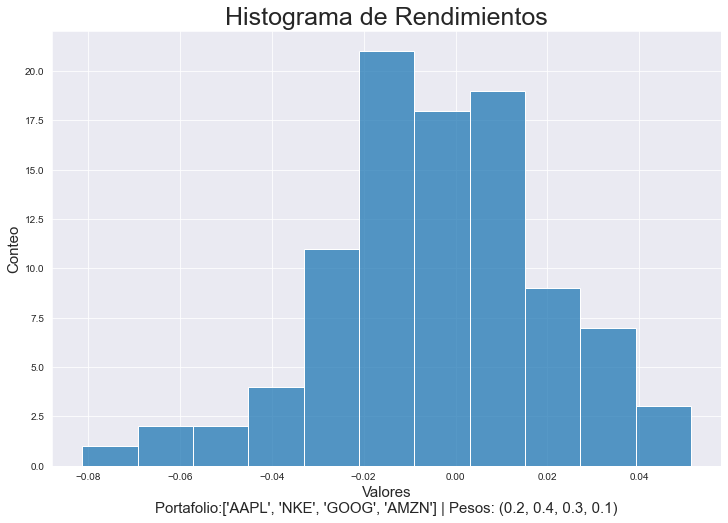

In [5]:
sns.set_style("darkgrid")
plt.figure(figsize = (12,8))
ax = sns.histplot(x)
ax.set_title("Histograma de Rendimientos",fontsize = '25')
ax.set_xlabel("Valores\nPortafolio:{0} | Pesos: {1}".format(tickers,w),fontsize = 15)
ax.set_ylabel("Conteo",fontsize = 15)
plt.show()

In [6]:
x.describe()

count    97.000000
mean     -0.003775
std       0.024181
min      -0.081265
25%      -0.018564
50%      -0.001852
75%       0.011850
max       0.051266
dtype: float64

### 3- Calcula la matriz de covarianza y muestra a la matriz.

Consideremos la aplicación de los pesos $w$:

In [7]:
(log_returns*w).cov()*252

,AAPL,AMZN,GOOG,NKE
AAPL,0.004840,0.010117,0.005944,0.001841
AMZN,0.010117,0.047291,0.016112,0.004897
GOOG,0.005944,0.016112,0.012092,0.002670
NKE,0.001841,0.004897,0.002670,0.001472


In [8]:
(log_returns*w).corr()

,AAPL,AMZN,GOOG,NKE
AAPL,1.000000,0.668682,0.776930,0.689806
AMZN,0.668682,1.000000,0.673788,0.586957
GOOG,0.776930,0.673788,1.000000,0.632974
NKE,0.689806,0.586957,0.632974,1.000000


In [9]:
(log_returns*w).mean()

AAPL   -0.000577
AMZN   -0.001916
GOOG   -0.000884
NKE    -0.000437
dtype: float64

Sin aplicar pesos:

In [10]:
log_returns.cov()*252

,AAPL,AMZN,GOOG,NKE
AAPL,0.121003,0.126458,0.099062,0.092057
AMZN,0.126458,0.295569,0.134270,0.122424
GOOG,0.099062,0.134270,0.134355,0.089011
NKE,0.092057,0.122424,0.089011,0.147185


In [11]:
log_returns.corr()

,AAPL,AMZN,GOOG,NKE
AAPL,1.000000,0.668682,0.776930,0.689806
AMZN,0.668682,1.000000,0.673788,0.586957
GOOG,0.776930,0.673788,1.000000,0.632974
NKE,0.689806,0.586957,0.632974,1.000000


In [12]:
log_returns.mean()

AAPL   -0.002886
AMZN   -0.004790
GOOG   -0.002948
NKE    -0.004370
dtype: float64

En lo general, podemos observar que los activos están muy correlacionados. Además, es imperativo observar que TODOS los rendimientos son negativos, cuestión que impactará al momento de realizar la gráfica de los portafolios admisibles.

### 4. Construye la barrera eficiente de Markowitz para el portafolio.

Para la obtención de la barrera eficiente obtendremos los diferentes niveles posibles de returns para el portafolio y obtendremos el portafolio de Markowitz, en este caso el que minimiza la varianza dado un nivel de rendimientos esperado, de esta manera, este portafolio minimiza la varianza dado un nivel de rendimientos admisible, y esto se hará para todos los posibles niveles de rendimientos, a continuación graficaremos y obtendremos la barrera eficiente.

Note que estamos utilizando el enfoque de minimización de volatilidad dado un nivel de rendimientos esperado para la obtención de los diferentes portafolios de Markowitz, dicho enfoque puede ser encontrado en las diapositivas enviadas al inicio del curso:

<img src = "https://raw.githubusercontent.com/ArathReyes/Efficient-Frontier/main/gallery/markowitz.PNG"/>

Además que dicho enfoque es consistente con la definción de barrera eficiente según <a href="https://www.investopedia.com/terms/e/efficientfrontier.asp#:~:text=The%20efficient%20frontier%20is%20the,for%20the%20level%20of%20risk.">Investopedia</a>:

*The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or* **the lowest risk for a given level of expected return**

In [13]:
medias = log_returns.mean()*252 # Rendimientos
cov = log_returns.cov()*252 # Matriz de covarianzas
cov = cov.values

In [14]:
size= len(tickers) # Cantidad de elementos en el portafolio

Para minimizar utilizaremos SciPy.optimize.minimize, para más información <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html">[Consulte]</a>:

In [15]:
# Función a minimizar
def compute_portfolio_variance(x, covariance_matrix):
    variance = np.dot(x.T, np.dot(covariance_matrix, x)).item()
    return variance

In [16]:
def Markowitz(size, cov, medias, target):
    # initialise optimisation
    x = np.zeros([size,1])
    # initialise constraints
    cons = [{"type": "eq", "fun": lambda x: np.transpose(medias).dot(x).item() - target},\
            {"type": "eq", "fun": lambda x: sum(abs(x)) - 1}]
    bnds = [(0, None) for i in range(size)]
    # compute optimisation
    res = minimize(compute_portfolio_variance, x, args=(cov), constraints=cons, bounds=bnds)
    weights =  res.x
    return weights

In [17]:
Markowitz(size, cov, medias, -1.15909081) # Ejemplo

array([0.00000000e+00, 5.46468018e-01, 5.46437895e-17, 4.53531982e-01])

In [18]:
# Para obtener el rango posible de rendimientos
minret = min(medias)
maxret = max(medias)

In [19]:
# Discretización del intervalo de posibles rendimientos
returns = minret + np.linspace(0.1,0.9,1000) * (maxret-minret)

In [20]:
volatilities = np.zeros([len(returns),1])

In [21]:
counter = 0
for target in returns:
    w = Markowitz(size, cov, medias, target)
    volatilities[counter] = np.sqrt(np.dot(w.T, np.dot(cov, w)))
    counter += 1

In [22]:
volatilities = [i[0] for i in volatilities]

In [23]:
frontera = pd.DataFrame({"Volatilidad":volatilities,"Return":returns})

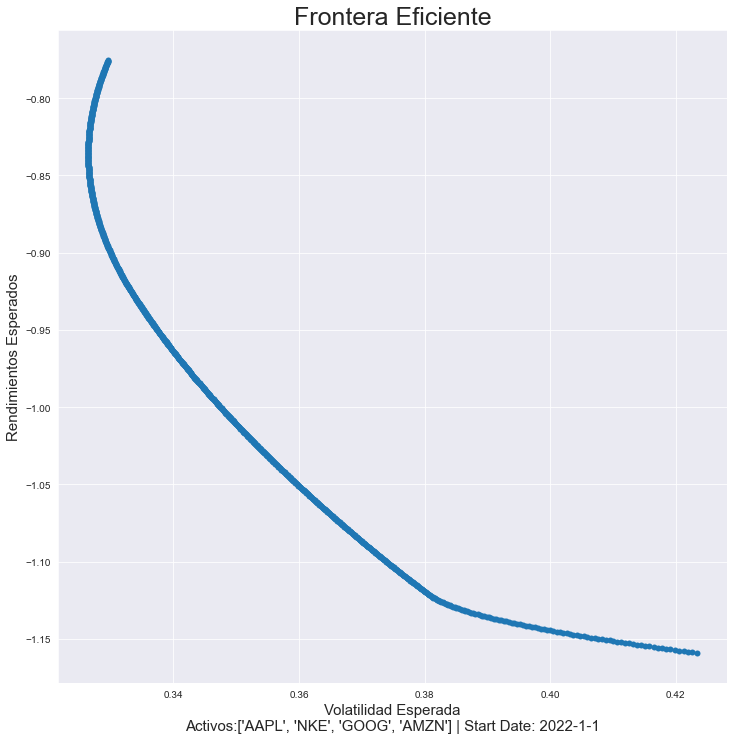

In [24]:
sns.set_style("darkgrid")
plt.figure(figsize = (12,12))
ax = sns.scatterplot(x = volatilities,y = returns,linewidth=0)
ax.set_title("Frontera Eficiente", fontsize = 25)
ax.set_xlabel("Volatilidad Esperada\nActivos:{0} | Start Date: {1}".format(tickers,start),fontsize = 15)
ax.set_ylabel("Rendimientos Esperados",fontsize = "15")
plt.show()

Además, mostrermos el conjunto de portafolios admisible:

In [25]:
n = 2500

port_returns = []
port_vol = []
port_w = []
for _ in range(n):
    w = np.random.random(len(tickers))
    w /= np.sum(w)
    port_w.append(w)
    port_returns.append(np.sum(w * log_returns.mean()) * 252)
    port_vol.append(np.sqrt(np.dot(w.T, np.dot(log_returns.cov() * 252, w))))
                    
port_returns = np.array(port_returns)
port_vol = np.array(port_vol)     

In [26]:
portafolios = pd.DataFrame({"Pesos":port_w,'Return': port_returns, 'Volatilidad':port_vol})

In [27]:
rf = 0.0
portafolios["Sharpe"] = (portafolios["Return"] - rf)/portafolios["Volatilidad"]
max_port = portafolios[portafolios.Sharpe == max(portafolios.Sharpe)]
max_port = max_port.reset_index(drop=True)

In [28]:
max_sharpe = round(max_port["Sharpe"].values[0],3)
max_port_w = max_port["Pesos"].values[0]

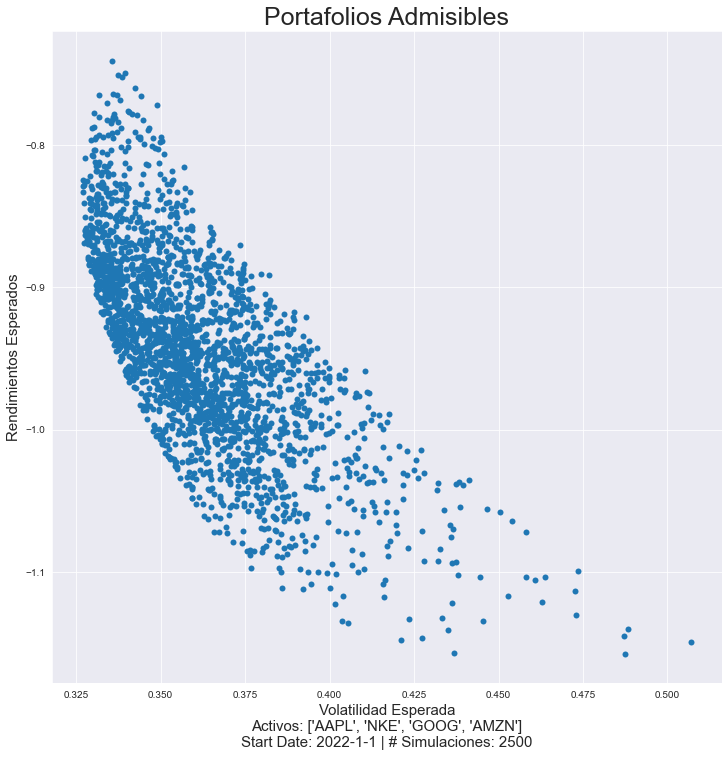

In [29]:
sns.set_style("darkgrid")
plt.figure(figsize = (12,12))
ax = sns.scatterplot(x = "Volatilidad",y = "Return",data = portafolios, linewidth=0)
ax.set_title("Portafolios Admisibles",fontsize = '25')
ax.set_ylabel("Rendimientos Esperados",fontsize = "15")
ax.set_xlabel("Volatilidad Esperada\n"+"Activos: "+str(tickers)+\
              "\nStart Date: "+start+" | # Simulaciones: "+str(n),fontsize = "15")
plt.show()

Notemos que nuestra frontera eficiente es consistente con la nube de portafolios admisibles obtenida vía el método de Monte Carlo.

### 5. A través del método Monte-Carlo, realiza una simulación en donde además se muestre el coeficiente de Sharpe.

Mostremos el portafolio que maximiza el cociente de Sharpe:

In [30]:
print("El cociente de Sharpe para el portafolio {0} más grande está dado por:{1}\nAdemás,\
 note que los pesos de dicho portafolio son: {2}".format(tickers, max_sharpe,max_port_w))

El cociente de Sharpe para el portafolio ['AAPL', 'NKE', 'GOOG', 'AMZN'] más grande está dado por:-2.206
Además, note que los pesos de dicho portafolio son: [0.50681989 0.00245154 0.47792728 0.01280129]


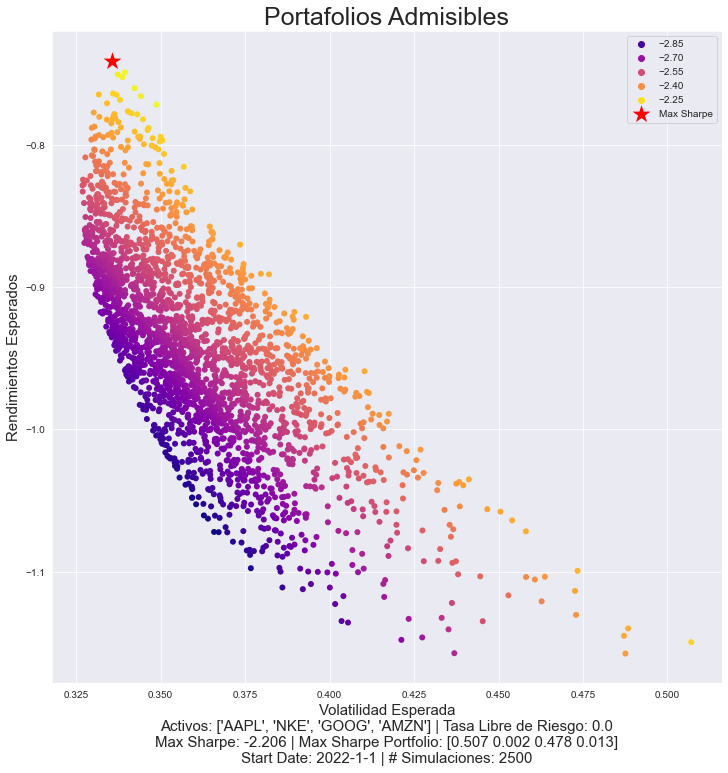

In [31]:
# viridis, plasma
sns.set_style("darkgrid")
plt.figure(figsize = (12,12))
ax = sns.scatterplot(x = "Volatilidad",y = "Return",data = portafolios, hue = "Sharpe",\
                     palette='plasma',linewidth=0)
sns.scatterplot(x = "Volatilidad",y = "Return", data = max_port, color = "red",\
                label = "Max Sharpe",s = 350, marker="*",linewidth=0)
ax.set_title("Portafolios Admisibles",fontsize = '25')
ax.set_ylabel("Rendimientos Esperados",fontsize = "15")
ax.set_xlabel("Volatilidad Esperada\n"+"Activos: "+str(tickers)+\
              " | Tasa Libre de Riesgo: "+str(rf)+"\nMax Sharpe: "+str(max_sharpe)+\
              " | Max Sharpe Portfolio: "+str(np.round(list(max_port["Pesos"]),3)[0])+\
              "\nStart Date: "+start+" | # Simulaciones: "+str(n),fontsize = "15")
plt.show()

# Disclaimer:
Como puede observar, tanto la frontera eficiente como la nube de portafolios admisibles presentan comportamientos extraños, supuestamente ocasionados por el hecho de que los rendimientos son negativos, por ello recomendamos ver los siguientes portafolios para comprobar el código, inclusive podrá ver que se usa un ejemplo visto en clase:

In [32]:
# PORTAFOLIO VISTO EN LA CLASE DEL 18-05-2022
"""
Utilice estos tickers con fecha de inicio start y fecha final end como se tienen abajo.
"""
tickers = ["AAPL","MSFT","TWTR","IBM"]
start = "2020-1-1"
end = "2022-5-18"

Obtendrá resulados similares a los siguientes:
<img src = "https://raw.githubusercontent.com/ArathReyes/Efficient-Frontier/main/gallery/ej_3.png"/>
<img src = "https://raw.githubusercontent.com/ArathReyes/Efficient-Frontier/main/gallery/ej_4.png"/>

In [33]:
"""
Utilice estos tickers con fecha de inicio start y fecha final end como se tienen abajo.
"""
tickers = ["OIL","KO","IBM"]
start = "2020-1-1"
end = "2022-5-18"

Obtendrá resulados similares a los siguientes:
<img src = "https://raw.githubusercontent.com/ArathReyes/Efficient-Frontier/main/gallery/ej_1.png"/>
<img src = "https://raw.githubusercontent.com/ArathReyes/Efficient-Frontier/main/gallery/ej_2.png"/>